# Weapon Performance Analyzer

for EVE online (www.eveonline.com) using game log files stored on local machine

crafted by Khlaa Sor of KS Endeavours (*work in progress, improvement suggestions welcome via in-game mail*)

In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid") #  setting the visualization style
sns.set_context("notebook") # setting the visualization scale
import numpy as np
%matplotlib inline

## 1. Data selection and acquisition.

In [2]:
# Gamelogs directory path - unique for each user. 
w_dir = input('Gamelogs directory path: ') + '\\'

# Building the list of log files potentially suitable for analysis
log_files = []
with os.scandir(w_dir) as all_files:
    for entry in all_files:
        if entry.stat().st_size > 512: # excluding very small files
            log_files.append(entry.name)

# Sorting the list of log files from newest down
log_files.sort(reverse=True)

# Looking for certain kind of targets
entity = input('Entity to search for (any part of name, Enter to skip): ')

if entity:
    traced = [] # list to hold file names where target of interest was detected
    for entry in log_files:
        path = w_dir + entry
        with open(path, encoding='utf-8') as file:
            if entity in file.read():
                traced.append(entry)

    if traced:
        log_files = traced
        print(f'Traced in the following op logs ({len(log_files)}):')
    else:
        print('No traces detected.')    
else: 
    print('Not specified')
    print(f'Acquired the following log files ({len(log_files)}):')

Gamelogs directory path:  C:\Users\Maksim Mislavskii\Documents\EVE\logs\Gamelogs
Entity to search for (any part of name, Enter to skip):  Foreman


Traced in the following op logs (23):


In [3]:
for entry in log_files:
    print(entry)

20210522_074826_91278319.txt
20210516_174916_91278319.txt
20210516_034629_91278319.txt
20210515_035039_91278319.txt
20210418_063805_91278319.txt
20210401_033501_91278319.txt
20210320_120527_91278319.txt
20210227_040050_91278319.txt
20210222_120053_91278319.txt
20210219_123459_91278319.txt
20210217_051352_91278319.txt
20210212_055014_91278319.txt
20210209_162702_91278319.txt
20210109_124933.txt
20210109_024921.txt
20210106_112151.txt
20201230_124438.txt
20201207_064735.txt
20201125_052524.txt
20201118_114110.txt
20201116_113401.txt
20201115_034812.txt
20201112_114005.txt


In [4]:
# Selecting the file to analyse
file_name = input('Log file name to analyze, Enter for latest: ')
if not file_name:
    file_name = log_files[0] # defaulting to the latest file

# Constructing the log file path
file_path = w_dir + file_name

Log file name to analyze, Enter for latest:  


In [5]:
# reading the file and getting rid of the tags in the process
with open(file_path) as log_file:
    lines = [re.sub('<.+?>', '', #  replacing each tag with empty string
                    line.strip() 
                   ) for line in log_file.readlines()]
if lines:
    print(f'Log data loaded: {len(lines)} entries')

Log data loaded: 3828 entries


In [6]:
# printing the log out line by line (commented out to avoid offending GitHub users with a wall of text)
#for line in lines:
#   print(line)
# (can change the code to print nice clearly readable log with no tags into a file)

## 2. Preparing the data for analisys with Pandas.

In [7]:
# Getting a list of all combat related entries:
combat = [line for line in lines if '(combat)' in line]

if entity:
    specific = input('Filter for selected kind of targets (1/Enter):') 
    if specific:
        print(f'Filtering for {entity}')
        combat = [line for line in combat if entity in line]

# Getting a list of damage-exchange entries (by filtering 'misses' and 'attempt' out)
# also replacing '(combat)' with '-' to use as a column separator
hits = [line.replace('(combat)', '-') for line in combat if ('misses' not in line) and ('attempt' not in line)]
# !!! some (PC) entity designations can result in them not being accounted for

# and preparing it for dataframing by turning each entry into a row of cells
hits = [line.strip('[ ').replace(' ]', '') for line in hits]  # cleaning the timestamps
# installing column separators '-' and performing the split
hits = [line.replace(' to ', ' - to - ').replace(' from ', ' - from - ').split(' - ')  for line in hits] 

# Taking only dealt damage entries
dealt = [entry for entry in hits if 'to' in entry]

# Creating the dataframe
columns = ['Time', 'Damage', 'Direction', 'Entity', 'Weapon', 'Token']
dealt_df = pd.DataFrame(data=dealt, columns=columns)

dealt_df.Damage = dealt_df.Damage.astype('int')  # casting the damage scores to integer
# dealt_df
# dealt_df.describe(include='all')

Filter for selected kind of targets (1/Enter): 


## 3. Analysing the data and displaying results

In [8]:
# function to produce a list of explode values for pie charts
def pie_exploder(vals):
    """
    :vals: a list of values to be represented by the pie vedges, sorted in descending order for best results
    :return: a list of explode values for pie charts to only explode very narrow vedges
    :required: numpy
    """
    e = 0.01 # default explode value for all vedges
    explode = np.zeros(len(vals)) + e # generating default list of uniform explode values with numpy
    i = 0
    for val in vals:
        if val / sum(vals) < 0.03: #  tiny vedge qualification treshold (fraction of the total sum)
            explode[i] = e #  default explode value is applied unchanged on the first tiny vedge instance
            e += 0.05 #  incrementing the explode value starting from the second encountered tiny vedge
        i += 1

    return explode

### 3.1. Summary Stats

In [9]:
enemies = dealt_df.Entity.unique().tolist() #  making a list of all targets damage was applied to
print(f'Activated weapons on {len(enemies)} kinds of targets:')
for enemy in enemies:
    print(f' - {enemy}')
print()
weapons = dealt_df.Weapon.unique().tolist() #  making a list of weapons used to apply damage
print(f'Used {len(weapons)} types of weapon systems:')
for weapon in weapons:
    print(f' - {weapon}')
print()

Activated weapons on 18 kinds of targets:
 - Centii Enslaver
 - Centii Slavehunter
 - Centii Savage
 - Centum Mutilator
 - Centii Ravener
 - Centii Plague
 - Centatis Phantasm
 - Centii Butcher
 - Centum Slaughterer
 - Centum Torturer
 - Centum Execrator
 - Centatis Specter
 - Centum Beast
 - Centii Scavenger
 - Centii Servant
 - Centii Minion
 - True Sansha Foreman
 - Centatis Wraith

Used 6 types of weapon systems:
 - Hobgoblin II
 - Acolyte II
 - Mjolnir Light Missile
 - Infiltrator II
 - Hammerhead II
 - Mjolnir Fury Light Missile



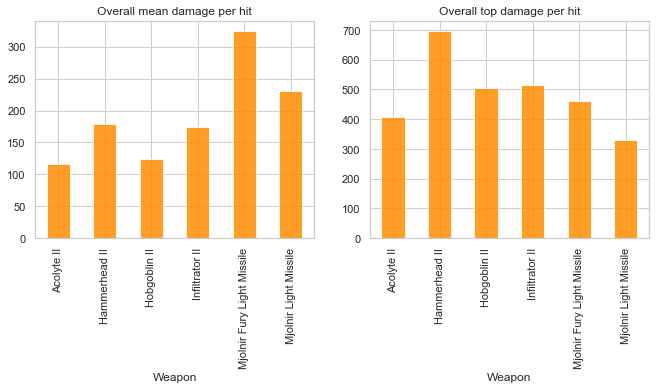

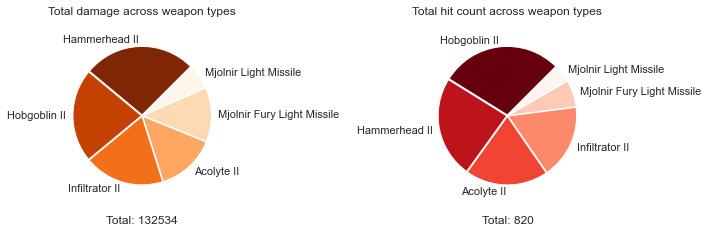

In [10]:
if weapons:
    # Data for plotting
    means_per_weapon = dealt_df.groupby(['Weapon']).Damage.mean()
    totals_per_weapon = dealt_df.groupby(['Weapon']).Damage.sum().sort_values(ascending=False)
    tops_per_weapon = dealt_df.groupby(['Weapon']).Damage.max()
    hits_per_weapon = dealt_df.Weapon.value_counts()

    #  Barcharts of mean and top damage scores per weapon
    plt.figure(figsize=(11,4)) 

    plt.subplot(121)
    means_per_weapon.plot(
        kind='bar', ylabel='', title='Overall mean damage per hit', 
        color='darkorange', alpha=.85
    )

    plt.subplot(122)
    tops_per_weapon.plot(
        kind='bar', ylabel='', title='Overall top damage per hit', 
        color='darkorange', alpha=.85
    )

    plt.show()

    # Piecharts of total damage and hit counts per weapon
    plt.figure(figsize=(12,3.5), facecolor='white') 

    plt.subplot(121,
               xlabel=f'Total: {sum(totals_per_weapon)}') #  plotting total damage per weapon
    totals_per_weapon.plot(
        kind='pie', title='Total damage across weapon types', ylabel='',
        radius=.9,
        cmap='Oranges_r',
        startangle = 45,
        explode = pie_exploder(totals_per_weapon)
    )

    plt.subplot(122,
                xlabel=f'Total: {sum(hits_per_weapon)}') #  plotting total number of hits per weapon
    hits_per_weapon.plot(
        kind='pie', title='Total hit count across weapon types', ylabel='',
        radius=.9,
        cmap='Reds_r',
        startangle = 45,
        explode = pie_exploder(hits_per_weapon)
    )

    plt.show()
    
else:
    print('No meaningful interactions to analyze.')

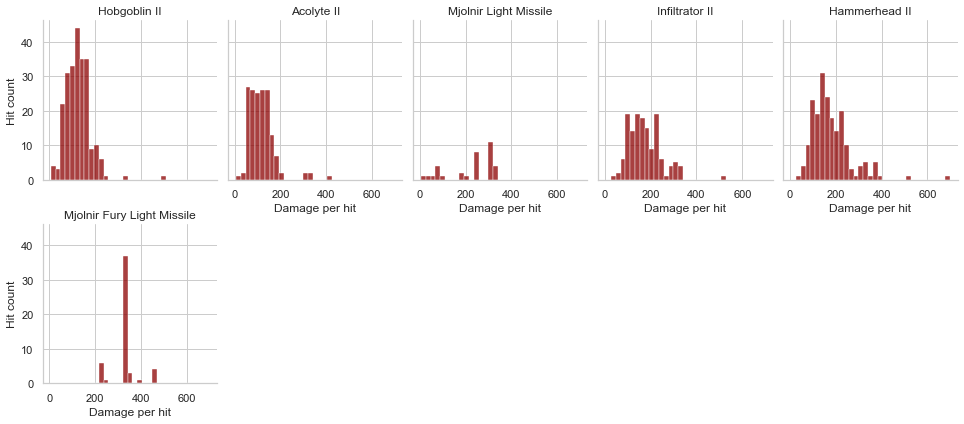

In [16]:
# Generating hit quality histograms with Seaborn
g = sns.displot(
    data=dealt_df, x="Damage", col="Weapon",
    col_wrap=5,
    height=3, aspect=.9, color='darkred'
)
g.set_axis_labels("Damage per hit", "Hit count")
g.set_titles("{col_name}")
plt.show()

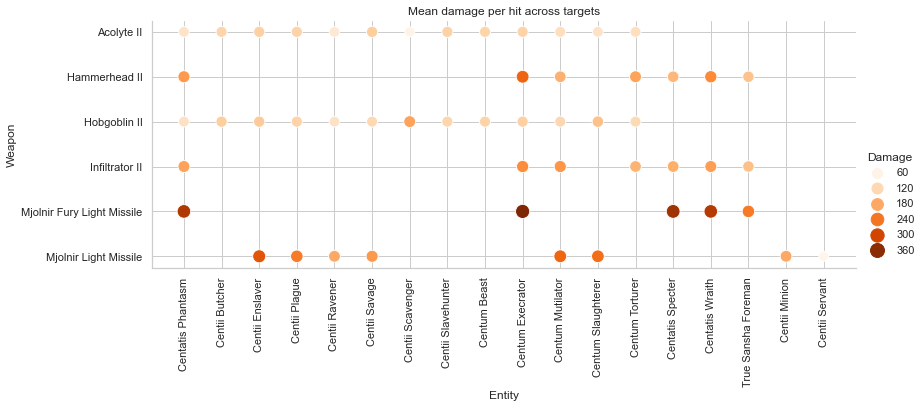

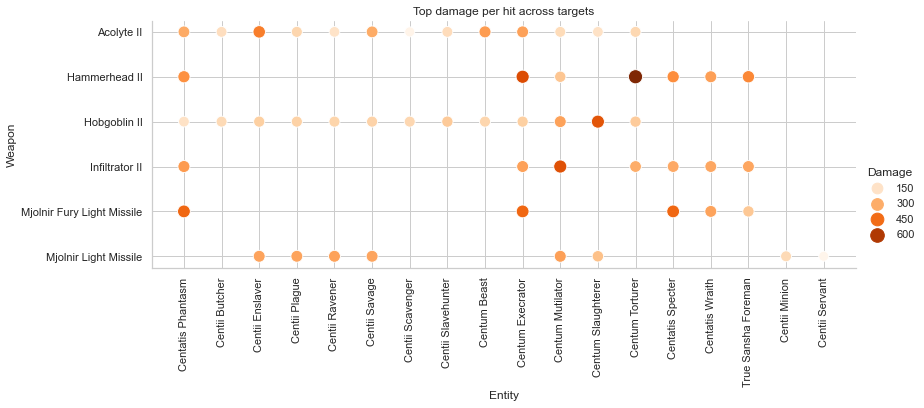

In [12]:
# Plotting mean and top damage scores per weapon across all targets with seaborn
if weapons:
    # Data for plotting
    mean_damage_scores = pd.DataFrame(dealt_df.groupby(['Weapon', 'Entity']).Damage.mean())
    top_damage_scores = pd.DataFrame(dealt_df.groupby(['Weapon', 'Entity']).Damage.max())

    # Mean damage
    sns.relplot(y="Weapon", x="Entity", hue="Damage", size='Damage',
                data=mean_damage_scores, 
                height=4, aspect=3, 
                palette='Oranges', sizes=(100, 200)
        )
    plt.tick_params(axis='x', rotation=90)
    plt.title('Mean damage per hit across targets')
    plt.show()

    # Top damage
    sns.relplot(y="Weapon", x="Entity", hue="Damage", size='Damage',
                data=top_damage_scores, 
                height=4, aspect=3, 
                palette='Oranges', sizes=(100, 200)
        )
    plt.tick_params(axis='x', rotation=90)
    plt.title('Top damage per hit across targets')
    plt.show()

**Alfa strike per weapon per target (top and bottom if much data):**

In [13]:
if weapons:
    if len(top_damage_scores) > 14:
        print(top_damage_scores.sort_values(by='Damage', ascending=False).head(7), end='\n'*2)
        print(top_damage_scores.sort_values(by='Damage', ascending=False).tail(7), end='\n'*2)
    else:
        print(top_damage_scores.sort_values(by='Damage', ascending=False), end='\n'*2)

                                               Damage
Weapon                     Entity                    
Hammerhead II              Centum Torturer        697
                           Centum Execrator       526
Infiltrator II             Centum Mutilator       515
Hobgoblin II               Centum Slaughterer     506
Mjolnir Fury Light Missile Centum Execrator       461
                           Centatis Phantasm      461
                           Centatis Specter       461

                                          Damage
Weapon                Entity                    
Acolyte II            Centii Slavehunter     172
                      Centii Butcher         164
                      Centum Slaughterer     151
Hobgoblin II          Centatis Phantasm      151
Acolyte II            Centii Ravener         146
                      Centii Scavenger        62
Mjolnir Light Missile Centii Servant          55



### 3.2. Weapons performance on each target


Performance on Centii Enslaver:



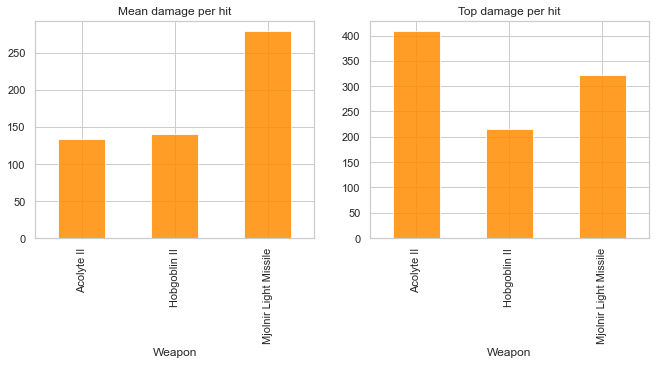

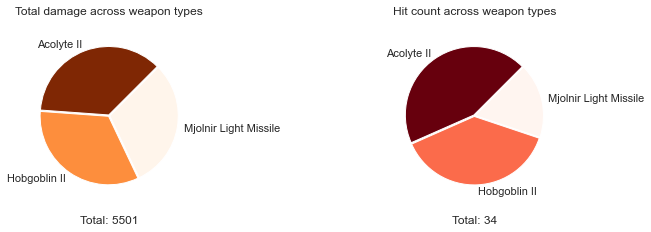

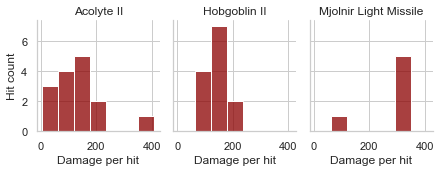



Performance on Centii Slavehunter:



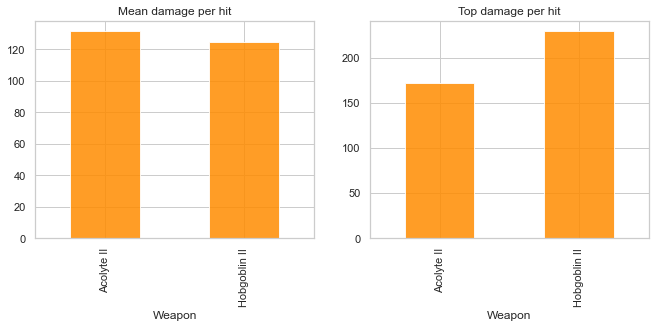

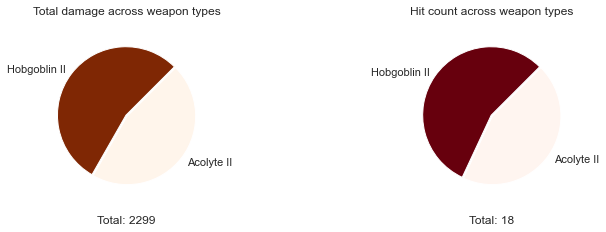

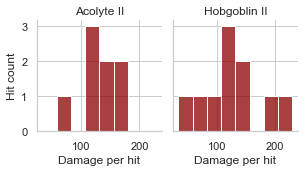



Performance on Centii Savage:



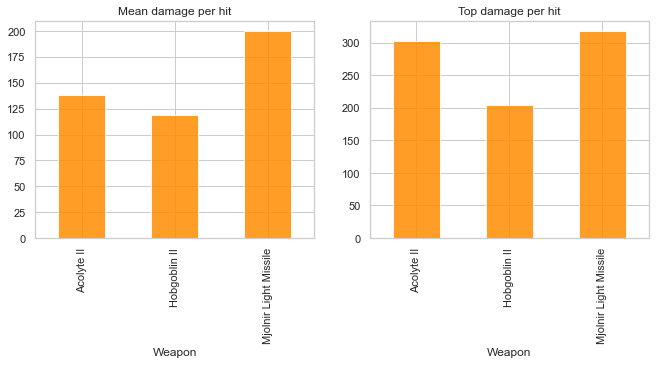

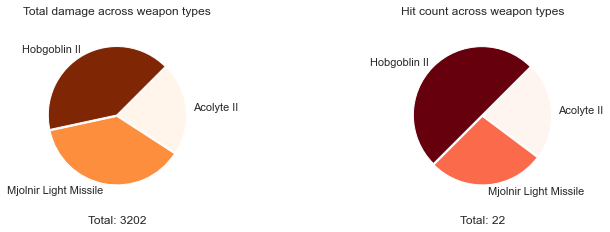

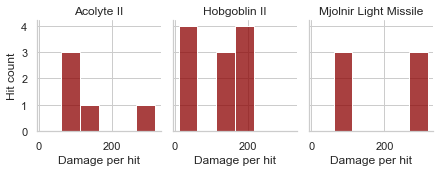



Performance on Centum Mutilator:



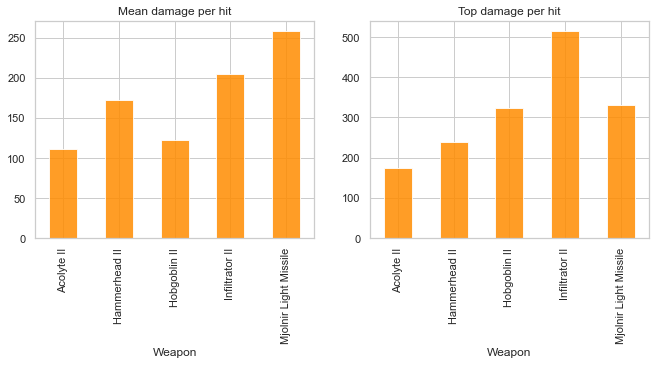

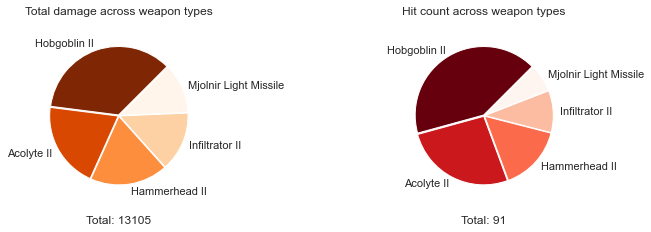

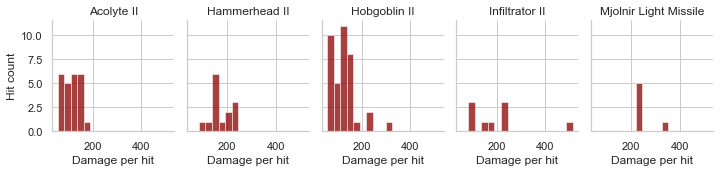



Performance on Centii Ravener:



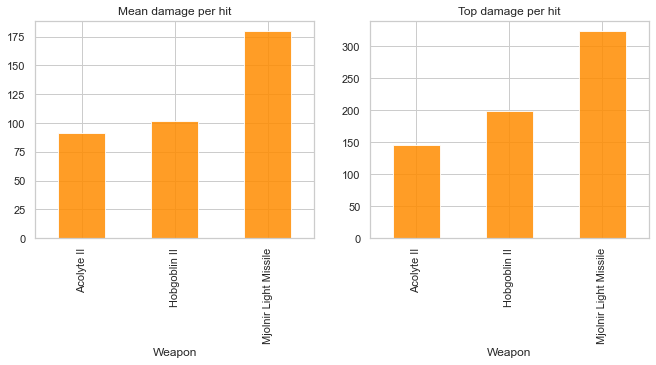

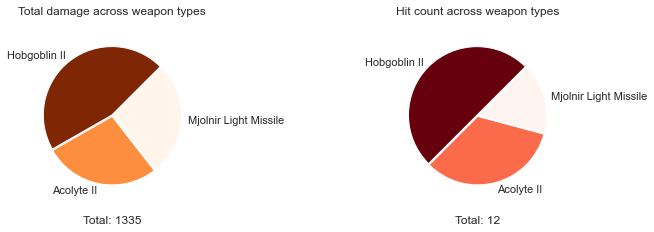

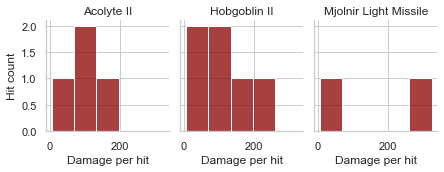



Performance on Centii Plague:



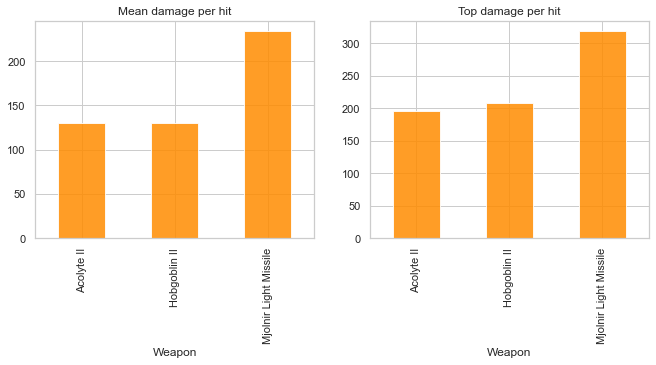

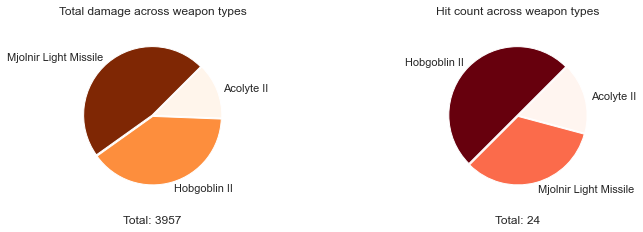

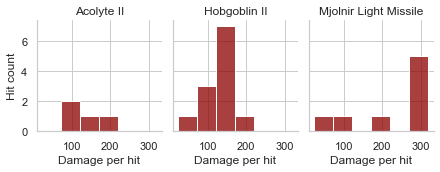



Performance on Centatis Phantasm:



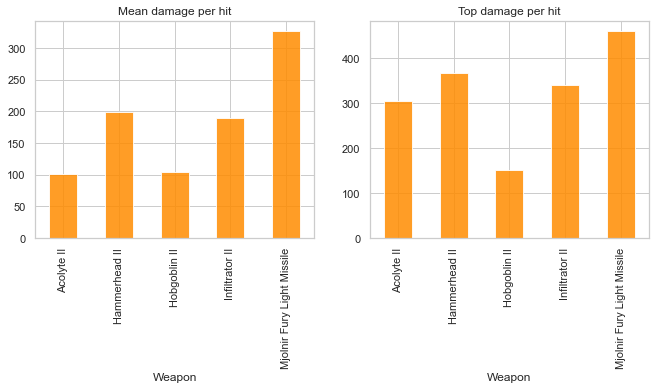

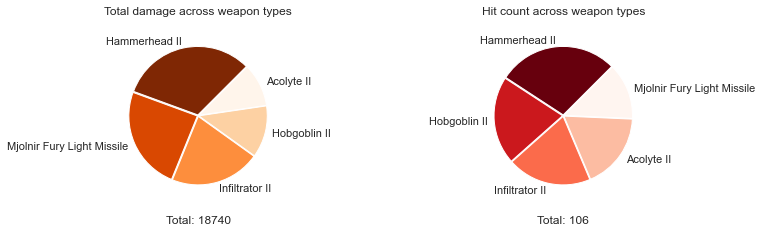

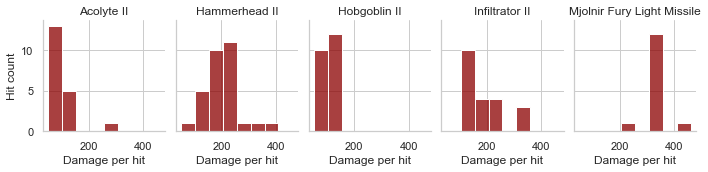



Performance on Centii Butcher:



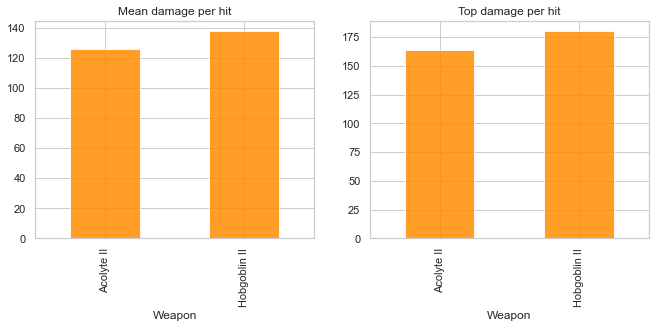

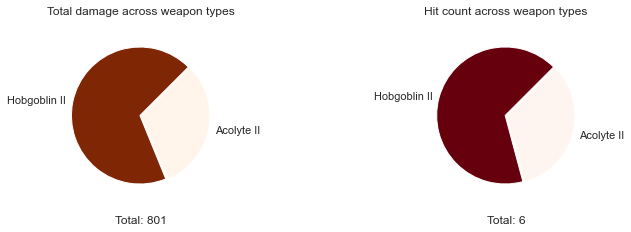

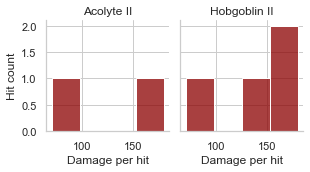



Performance on Centum Slaughterer:



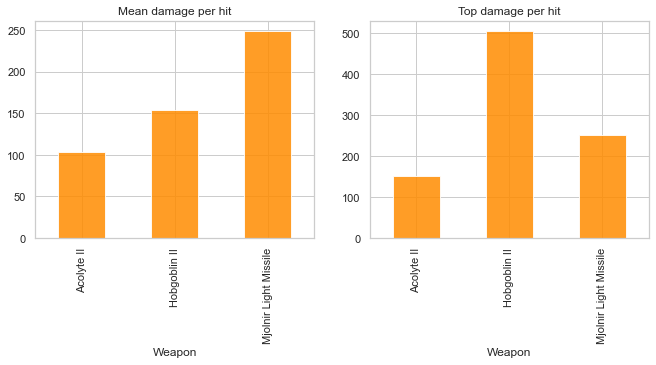

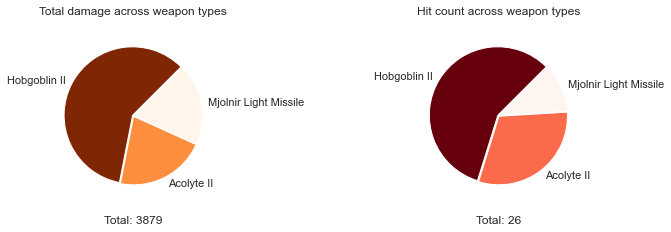

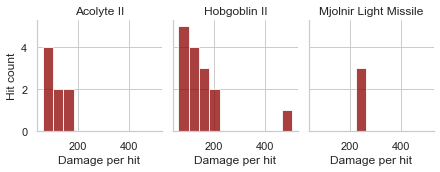



Performance on Centum Torturer:



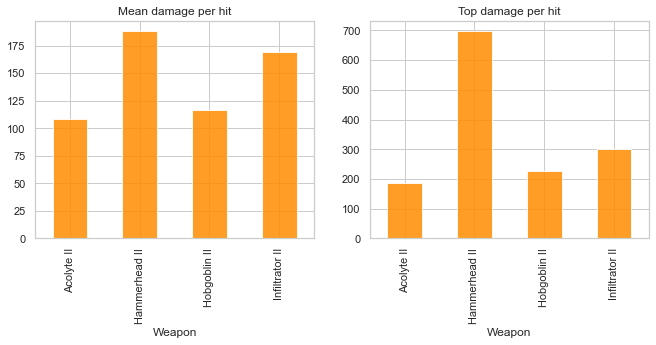

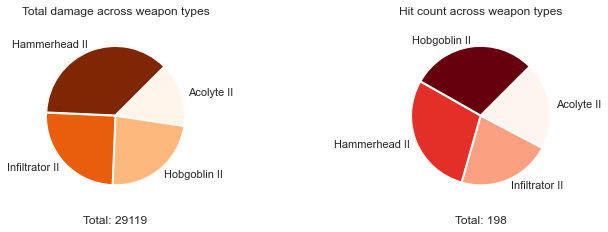

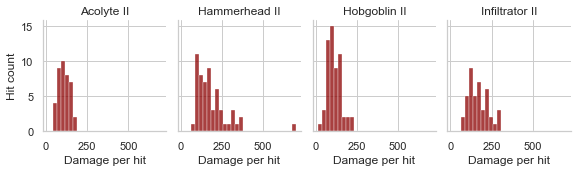



Performance on Centum Execrator:



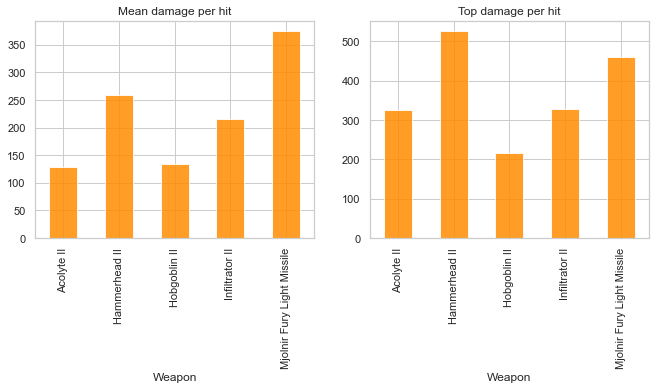

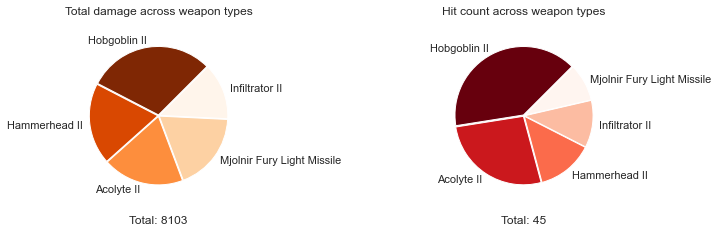

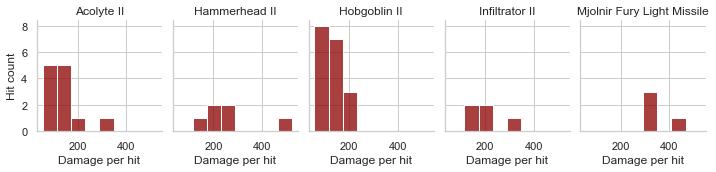



Performance on Centatis Specter:



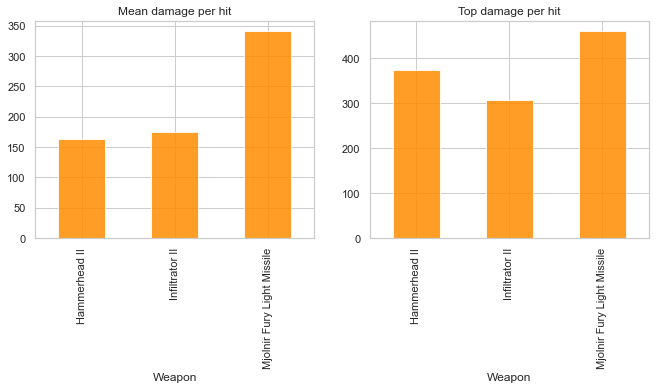

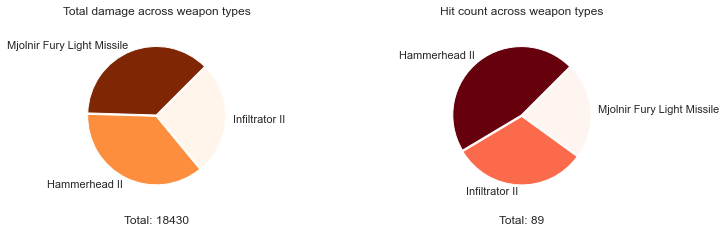

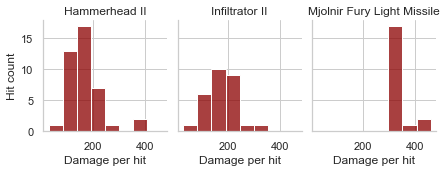



Performance on Centum Beast:



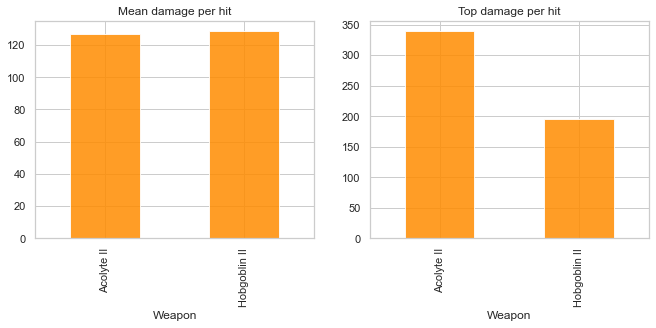

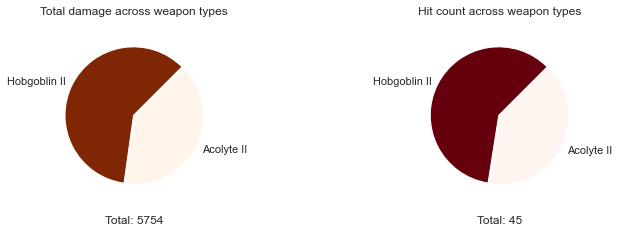

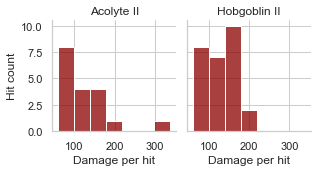



Performance on Centii Scavenger:



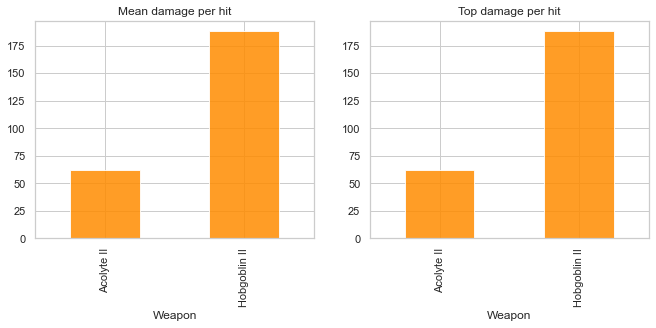

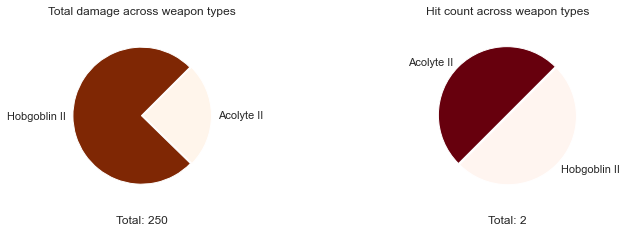

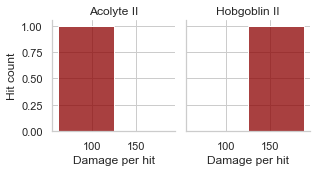



Performance on Centii Servant:



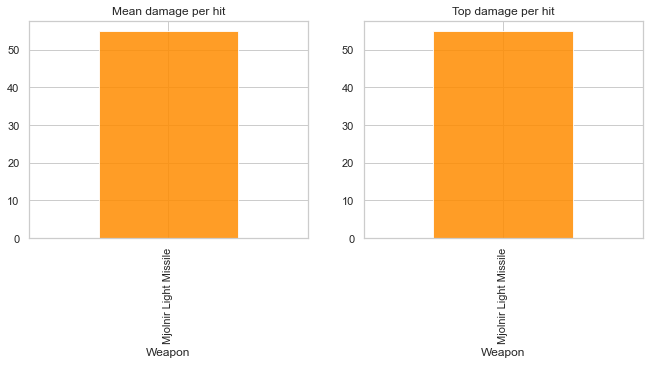

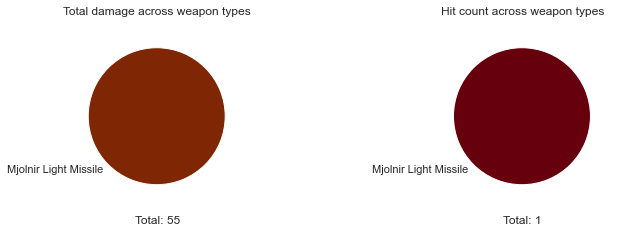

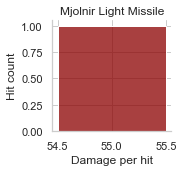



Performance on Centii Minion:



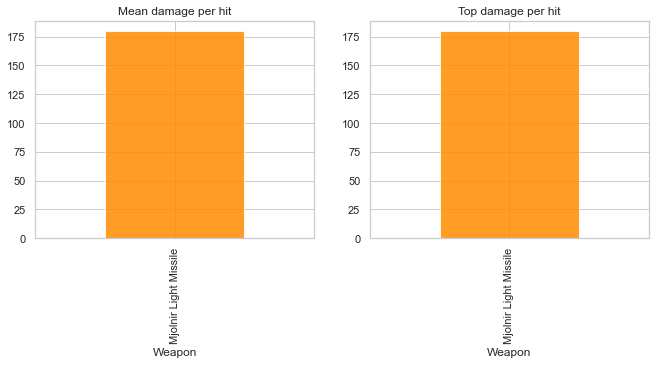

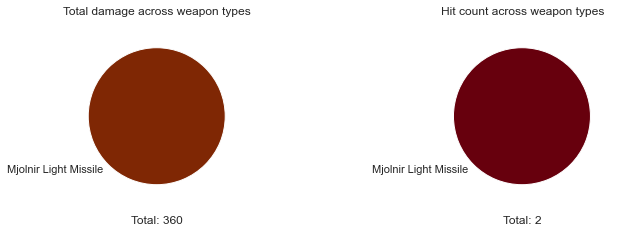

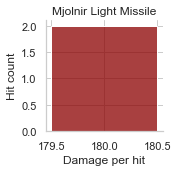



Performance on True Sansha Foreman:



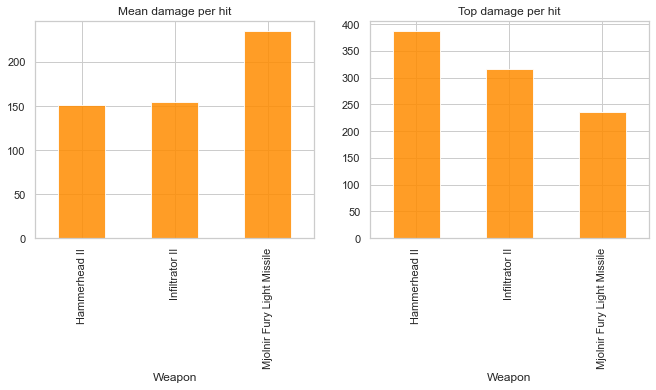

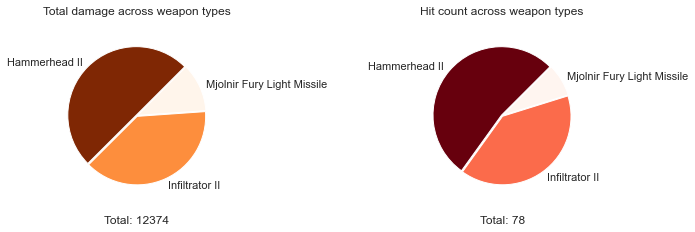

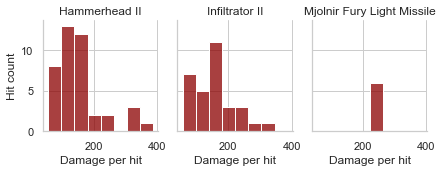



Performance on Centatis Wraith:



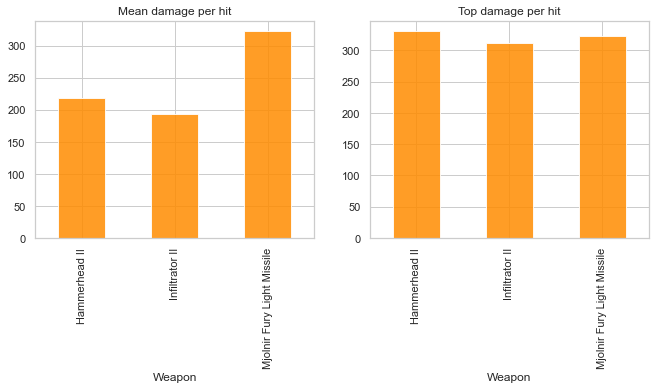

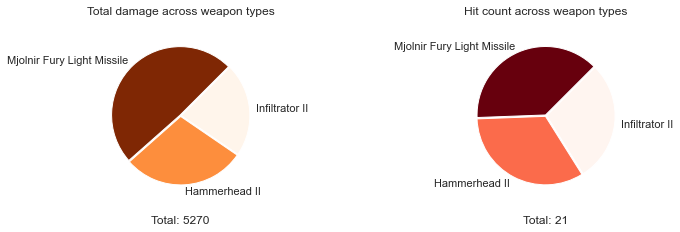

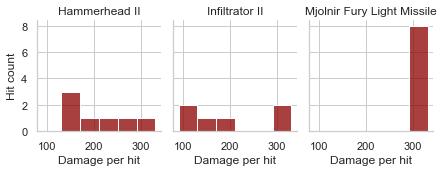

In [19]:
for enemy in enemies:
    print(f'\nPerformance on {enemy}:', end='\n'*2)
    
    # Data on current target
    data_slice = dealt_df[dealt_df.Entity == enemy].sort_values(by='Weapon')
    
    if sum(totals_per_weapon) > 0:
        
        # Mean and top damage barcharts
        plt.figure(figsize=(11,4)) 
        
        plt.subplot(121) #  plotting mean damage per hit per weapon 
        data_slice.groupby('Weapon').Damage.mean().plot(
            kind='bar', title='Mean damage per hit',
            ylabel='', 
            color='darkorange', alpha=.85
        )
        plt.subplot(122) #  plotting top damage per hit per weapon 
        data_slice.groupby('Weapon').Damage.max().plot(
            kind='bar', title='Top damage per hit', ylabel='', 
            color='darkorange', alpha=.85
        )      
        
        plt.show()
        
        # Total damage and hit count pies
        totals_per_weapon = data_slice.groupby('Weapon').Damage.sum().sort_values(ascending=False)
        hits_per_weapon = data_slice.Weapon.value_counts().sort_values(ascending=False)
        
        plt.figure(figsize=(12,3.5), facecolor='white') 

        plt.subplot(121, #  plotting total damage across weapon types
                    xlabel=f'Total: {sum(totals_per_weapon)}')
        totals_per_weapon.plot(
            kind='pie', title='Total damage across weapon types',
            radius=.9,
            # center=(0,-5),
            cmap='Oranges_r',
            ylabel='', 
            startangle = 45,
            explode = pie_exploder(totals_per_weapon)
        )
        plt.subplot(122, #  plotting hit counts per weapon
                    xlabel=f'Total: {sum(hits_per_weapon)}') 
        hits_per_weapon.plot(
            kind='pie', title='Hit count across weapon types', ylabel='',
            cmap='Reds_r',
            radius=.9,
            startangle = 45,
            explode = pie_exploder(hits_per_weapon)
        )        
        
        plt.show()
        
        # Hit quality charts across weapon systems
        g = sns.displot(
            data=data_slice, x="Damage", col="Weapon",
            col_wrap=5,
            height=2.5, aspect=.8, color='darkred'
        )
        g.set_axis_labels("Damage per hit", "Hit count")
        g.set_titles("{col_name}")
        plt.show()
        print()

    else:
        print('- Zero damage scored', end='\n'*2)
        continue